This model applies an RNN to the EEG data.

In [1]:
!pip install torch>=1.2.0
!pip install torchaudio

     |████████████████████████████████| 3.2MB 3.5MB/s 


Load libraries.

In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from google.colab import drive
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchaudio.transforms import Spectrogram
from sklearn.metrics import confusion_matrix
import pandas as pd

Mount drive where data is stored.

In [0]:
drive.mount('/content/drive')

Pull dataset.

In [0]:
path_prefix = '/content/drive/Shared drives/CS 230 Project (EEG)/'
data = np.load(path_prefix + 'combined_subjects_data.npy')
labels = np.load(path_prefix + 'combined_subjects_analog_rts.npy')

Remove the extra high response times so that the very late responses come to a range where they are predictable by the model.

In [0]:
labels.shape

(26065, 1)

(array([ 670.,   53.,   49.,   55.,  511., 1718., 3154., 2927., 2726.,
        2364., 1892., 1405., 1072.,  750.,  587.,  467.,  408.,  328.,
         282.,  246.,  197.,  173.,  134.,  155.,  115.,  124.,  112.,
         113.,  104.,   90.,  110.,   87.,   79.,   86.,   91.,   88.,
          62.,   59.,   70.,   61.,   61.,   59.,   71.,   46.,   59.,
          39.,   50.,   47.,   47.,   36.,   50.,   38.,   48.,   33.,
          34.,   32.,   23.,   37.,   24.,   35.,   27.,   24.,   28.,
          27.,   26.,   27.,   26.,   24.,   23.,   22.,   22.,   19.,
          23.,   19.,   17.,   18.,   13.,   18.,   15.,   24.,   11.,
          27.,   29.,    7.,   15.,   11.,   13.,   14.,   13.,   11.,
          11.,   17.,   10.,   15.,    9.,   13.,   19.,    8.,   13.,
          10.]),
 array([0.012  , 0.11184, 0.21168, 0.31152, 0.41136, 0.5112 , 0.61104,
        0.71088, 0.81072, 0.91056, 1.0104 , 1.11024, 1.21008, 1.30992,
        1.40976, 1.5096 , 1.60944, 1.70928, 1.80912, 1.90896

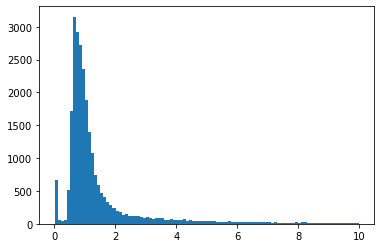

In [0]:
data = data[labels.reshape(-1,) <= 10]
labels = labels[labels <= 10]
plt.hist(labels, bins = 100)

Normalize all data across the channels.

In [0]:
means = np.sum(data, axis = (0,2), keepdims = True)/ (data.shape[0] * data.shape[2])
stds = np.sum(np.square(data - means), axis = (0,2), keepdims = True) / (data.shape[0] * data.shape[2])
stds = np.sqrt(stds)
data = (data - means)/stds

In [0]:
"""
rt_means = np.average(labels)
rt_std = np.std(labels)
labels = (labels - rt_means)/rt_std
"""

'\nrt_means = np.average(labels)\nrt_std = np.std(labels)\nlabels = (labels - rt_means)/rt_std\n'

Start running code on GPU. Should output true if GPU is being used.

In [0]:
# Start Device
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.cuda.is_available())

True


Plot one data sequence (500 points, 30 EEG channels from one session).

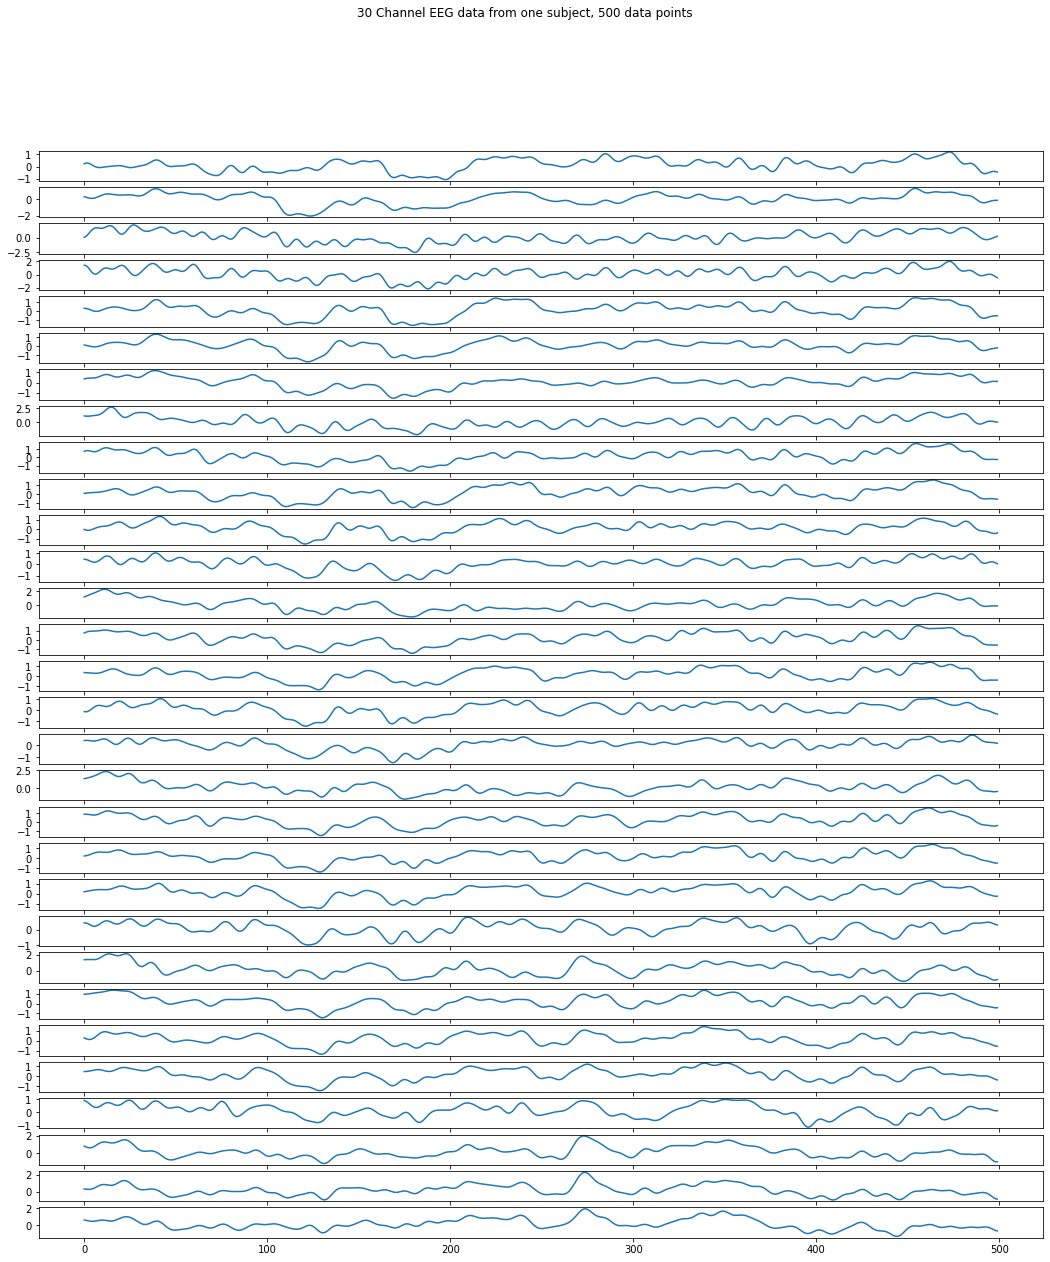

In [0]:
# define constants
N_EVENTS = data.shape[0]
N_CHAN = data.shape[1]
N_DATA_PTS = data.shape[2]

fig, axs = plt.subplots(N_CHAN)
fig.set_size_inches(18, 20)
fig.suptitle('30 Channel EEG data from one subject, 500 data points')
for i in range(data.shape[1]):
    axs[i].plot(data[0, i, :])

Define functions.

In [0]:
def preprocess(x, y):
    """
        Reshapes the data to size [N_EVENTS, N_CHAN, N_DATA_PTS].
        Args:
        x: torch.Tensor[N_EVENTS, N_CHAN*N_DATA_PTS]
        y: torch.Tensor[N_EVENTS]
    """
    return x.view(-1, N_CHAN, N_DATA_PTS).to(dev), y.to(dev)

class Flattener(nn.Module):
    """ 
        Flattens (reshapes) input of size [n_1, n_2, ...] to [n_1*n_2*..., 1].
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.view(-1, )
        
def get_data(dataset, bs, shuffle):
    """
        Returns an iterable torch.utils.data.DataLoader object that yields 
        batches from the dataset.
        Args: 
        dataset: torch.utils.data.TensorDataset
        bs: Batch Size (int)
        shuffle: Shuffles the dataset content (Bool)
    """
    return DataLoader(dataset, batch_size = bs, shuffle = shuffle)

class WrappedDataLoader:
    """
        Loads data in batches and applies preprocessing function.
        Args:
        func: function handle.
    """
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

def convert_to_dataset(data, labels, indices, bs, shuffle):
    """
    Converts Python data to torch.utils.data.DataLoader object.
    Args:
    data: EEG signal [N_EVENTS, N_CHAN, N_DATA_PTS]
    labels: Reaction Time Label (0, 1), [N_EVENTS,]
    indices: indices corresponding to either train, validation or test sets (int)
    bs: Batch Size (int)
    shuffle: (Bool)
    """
    x, y = data[indices], labels[indices]

    # Reshape dataset to (N_samples, W*H).
    x.reshape([x.shape[0], -1])
    y.squeeze()
    x = torch.tensor(x, dtype = torch.float)
    y = torch.tensor(y, dtype = torch.float)
    dataset = get_data(TensorDataset(x, y), bs, shuffle)
    return WrappedDataLoader(dataset, preprocess) 

def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    Computes loss across a batch.
    Args:
    model: the network object (torch.nn.Sequential)
    loss_func: loss function of the network (torch.nn.Functional)
    xb: batch data from torch.utils.data.DataLoader
    yb: batch label from torch.utils.data.DataLoader
    opt: optimizer (torch.optim)
    lr_decay_rate: learning rate decay rate
    """
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def split_dataset(data, labels, split_ratios):
    """
        Splits the dataset to train, validation and test sets.
        Args: 
        data: dataset [N_EVENTS, N_CHAN, N_DATA_PTS]
        labels: reaction time labels [N_EVENTS,]
        split_ratios: (out of 100) splitting ratios for train, validation and test sets (int) [3,]
    """
    dataset_indices = np.arange(data.shape[0])
    
    # set seed to obtain same results across trials
    #np.random.seed(0)
    
    # shuffle data indices 
    np.random.shuffle(dataset_indices)
    
    # split to train, validation and test sets
    train_indices =   dataset_indices[ : data.shape[0] * split_ratios[0] // 100]
    valid_indices =   dataset_indices[ data.shape[0] * split_ratios[0] // 100 : data.shape[0] * (split_ratios[0] + split_ratios[1]) // 100]
    test_indices  =   dataset_indices[ data.shape[0] * (split_ratios[0] + split_ratios[1]) // 100 : ]

    # convert to tensorflow dataloaders
    train_dl = convert_to_dataset(data, labels, train_indices, bs, True)
    valid_dl = convert_to_dataset(data, labels, valid_indices, 2 * bs, False)
    test_dl  = convert_to_dataset(data, labels, test_indices, 2 * bs, False )

    return train_dl, valid_dl, test_dl

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, lr_wrapper = None):
    """
    Trains the network.
    Args:
    epochs: number of epochs to train the network - hyperparameter (int)
    model: the network object (torch.nn.Sequential)
    loss_func: loss function of the network (torch.nn.Functional)
    opt: optimizer (torch.optim)
    train_dl: training data loader iterable (torch.utils.data.DataLoader)
    valid_dl: validation data loader iterable (torch.utils.data.DataLoader)
    lr_decay_rate = learning rate decay rate
    """
    for epoch in range(epochs):
        model.train()
        """
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        """
        train_losses, train_nums = zip(
            *[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl]
        )
        model.eval()
        with torch.no_grad():
            """
            train_losses, train_nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
            )
            """
            val_losses, val_nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        train_loss = np.sum(np.multiply(train_losses, train_nums)) / np.sum(train_nums)
        val_loss = np.sum(np.multiply(val_losses, val_nums)) / np.sum(val_nums)
        print("Epoch: ", epoch, ", Train Cost = ", train_loss, " Validation Cost: ", val_loss)
        #print("Epoch: ", epoch, " Validation Cost: ", val_loss)        
        if lr_wrapper is not None:
            lr_wrapper.step(val_loss)

In [0]:
class Reorder(nn.Module):
    """ 
        Reorders the axes from (N, C, Tx) to  (Tx, N, C).
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.permute(2, 0, 1)

class Channelize_Time(nn.Module):
    """ 
        Reorders the axes from (N, C, f, Tx) to  (N, C * Tx, f).
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        x = x.permute(0, 1, 3, 2)
        return x.contiguous().view(x.size(0), x.size(1) * x.size(2), x.size(3)).to(dev)

class LSTM_EEG(nn.Module): 
    def __init__(self, input_size = N_CHAN, hidden_size = 100, num_layers = 1, dropout = 0):
        super(LSTM_EEG, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, \
                            num_layers = num_layers, dropout = dropout)
    def forward(self, input):
        out, _ = self.lstm(input)
        return out[-1]      # output will be the last point in the time sequence to make a many-to-one prediction

class GRU_EEG(nn.Module): 
    def __init__(self, input_size = N_CHAN, hidden_size = 100, num_layers = 1, dropout = 0, return_sequence = False):
        super(GRU_EEG, self).__init__()
        self.return_sequence = return_sequence
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, \
                           num_layers = num_layers, dropout = dropout)
    def forward(self, input):
        out, _ = self.gru(input)
        if self.return_sequence:
            return out      # output will be all the time points in the sequence
        else:
            return out[-1]

In [0]:
def categorize(response_time):
    categories = torch.zeros(response_time.shape, dtype = torch.int32)
    # set the categories
    categories[response_time < 0.33] = 0     # 0 < rt < 330 ms
    categories[(response_time >= 0.33) & (response_time < 0.67)] = 1        # 330 ms <= rt < 670 ms
    categories[(response_time >= 0.67) & (response_time < 1.0)] = 2         # 670 ms <= rt < 1 s
    categories[(response_time >= 1.0) & (response_time < 1.33)] = 3         # 1 s <= rt < 1.33 s
    categories[(response_time >= 1.33) & (response_time < 1.67)] = 4        # 1.33 s <= rt < 1.67 s
    categories[(response_time >= 1.67) & (response_time < 2.0)] = 5         # 1.67 s <= rt < 2 s
    categories[(response_time >= 2.0)] = 6                                  # 2 s <= rt 
    return categories


In [0]:
def categorize2(response_time, decision_boundary):
    categories = torch.zeros(response_time.shape, dtype = torch.int32)
    # set the categories
    categories[response_time < decision_boundary] = 0                            # rt < 1.5 s
    categories[(response_time >= decision_boundary)] = 1                         # 1.5 s <= rt 
    return categories

In [0]:
def test(model, test_dl, many_channels = False, decision_boundary = 1.5):
    nums = 0
    correct_predictions = 0

    #Precision - how many positive predictions were correct 
    pos_pred = 0
    pos_true = 0

    #Recall - how many real positive values were detected
    pos_all = 0
    
    model.eval()
    if many_channels:
        cm = torch.zeros([7, 7])
    else:     
        cm = torch.zeros([2, 2])
    y_p = np.array([], dtype = float)
    with torch.no_grad():
        for xb, yb in test_dl:
            raw_predict = model(xb)
            
            if many_channels:
                predictions = categorize(raw_predict)
                yb = categorize(yb)
                cm += confusion_matrix(yb, predictions, [0, 1, 2, 3, 4, 5, 6])
            else:
                predictions = categorize2(raw_predict, decision_boundary)
                yb = categorize2(yb, decision_boundary)
                cm += confusion_matrix(yb, predictions, [0, 1])
                #Calculate precision
                pred_pos = torch.sum(predictions == 1)
                true_pos = (predictions == 1) * (yb == 1)
                true_pos = torch.sum(true_pos)
                pos_pred += pred_pos.cpu().numpy()
                pos_true += true_pos.cpu().numpy()

                #\print("True Positives: " + str(true_pos.cpu().numpy()))
                #print("Positive Predictions: " + str(pred_pos.cpu().numpy()))

                #Calculate recall
                all_pos = torch.sum(yb)
                pos_all += all_pos.cpu().numpy()

                #print("Actual Positives: " + str(all_pos.cpu().numpy()))
            
            #print(raw_predict)
            y_p = np.append(y_p, raw_predict.cpu().numpy())

            compare = (predictions == yb)
            correct = torch.sum(compare)
            correct_predictions = correct_predictions + correct
            nums = nums + yb.shape[0]
            #print("/////////////////////////")
        
    test_accuracy = correct_predictions.cpu().numpy() / nums
    
    print("Accuracy: " + str(test_accuracy))
    if not many_channels:
        precision = pos_true/pos_pred
        recall = pos_true/pos_all
        f1 = 2 * precision * recall / (precision + recall)
        
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        print("F1: " + str(f1))

    print("Confusion Matrix: ")
    print(pd.DataFrame(cm.cpu().numpy()))
    print(y_p.shape)
    plt.hist(y_p, bins = 100)

**Initialize Dataloaders**

Shuffle dataset and separate to train, validation and test sets. Clear dataset variables once read.

In [0]:
if data is not None:
    bs = 64         # batch size
    # Split the dataset into train (60%), validation (20%) and test (20%).
    train_dl, test_dl, valid_dl = split_dataset(data, labels, split_ratios = [60, 20, 20])

    # Clear dataset variables once read.
    data = None
    label = None

**Set hyperparameters**

In [0]:
lr = 1e-3                   # learning rate
epochs = 50                # how many epochs to train for
dropout = 0.2               # dropout probability for RNN
weight_decay = 0         # weight decay for Adam optimizer
lr_decay_rate = 1           # learning rate decay rate
# Set the loss function
#loss_func = F.mse_loss
#loss_func = F.poisson_nll_loss
loss_func = F.smooth_l1_loss
#loss_func = F.binary_cross_entropy

# Set seed for reproducibility, comment to make random
#torch.manual_seed(0)

### Initialize model

In [0]:
total_epochs = 0
N_HIDDEN = 512
N_GRU_LAYERS = 1
WIN_LENGTH = 50
N_BINS = N_DATA_PTS // WIN_LENGTH * 2 + 1
N_CONV_CHANNELS = 256
KERNEL_SIZE = 15
STRIDE = 1
# Best Model so far
# Initialize Spectrogram - 1D CNN - GRU Model
model = nn.Sequential(
    Spectrogram(win_length = WIN_LENGTH),
    Channelize_Time(),
    nn.Conv1d(in_channels = N_CHAN * N_BINS, out_channels = N_CONV_CHANNELS, \
              kernel_size = KERNEL_SIZE, stride = STRIDE, padding = 1),
    nn.BatchNorm1d(N_CONV_CHANNELS),
    nn.ReLU(),
    nn.Dropout(p = dropout),
    nn.Conv1d(in_channels = N_CONV_CHANNELS, out_channels = N_CONV_CHANNELS, \
              kernel_size = KERNEL_SIZE, stride = STRIDE, padding = 1),
    nn.BatchNorm1d(N_CONV_CHANNELS),
    nn.ReLU(),
    nn.Dropout(p = dropout),
    nn.Conv1d(in_channels = N_CONV_CHANNELS, out_channels = N_CONV_CHANNELS, \
              kernel_size = KERNEL_SIZE, stride=1, padding=1),
    nn.BatchNorm1d(N_CONV_CHANNELS),
    nn.ReLU(),
    nn.Dropout(p = dropout),
    Reorder(),
    GRU_EEG(input_size = N_CONV_CHANNELS, hidden_size = N_HIDDEN, 
            num_layers = N_GRU_LAYERS, dropout = dropout, return_sequence = False),
    nn.Dropout(p = dropout),
    nn.Linear(in_features = N_HIDDEN, out_features = N_HIDDEN),
    nn.BatchNorm1d(N_HIDDEN),
    nn.Tanh(),
    nn.Dropout(p = dropout),
    nn.Linear(in_features = N_HIDDEN, out_features = 1),
    Flattener()
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
# move model to GPU
model.to(dev)

# initialize optimizer and learning rate decay wrapper
opt = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
if lr_decay_rate != 1:
    lr_wrapper = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = lr_decay_rate, patience = 1, 
                                                      min_lr = 1e-8, verbose = True)
else:
    lr_wrapper = None

# Run RNN
total_epochs += epochs
print('Start training.')
fit(epochs, model, loss_func, opt, train_dl, valid_dl, lr_wrapper)
print('End of training.')

Start training.
Epoch:  0 , Train Cost =  0.1267267198436017  Validation Cost:  0.43926623590524067
Epoch:  1 , Train Cost =  0.14082262448018532  Validation Cost:  0.8873780350137128
Epoch:  2 , Train Cost =  0.12420664491086854  Validation Cost:  0.4429649559793072
Epoch:  3 , Train Cost =  0.11340741808482149  Validation Cost:  0.45214955055476314
Epoch:  4 , Train Cost =  0.10942140198875802  Validation Cost:  0.4556120427935969
Epoch:  5 , Train Cost =  0.11252272323353685  Validation Cost:  0.47655482838404334
Epoch:  6 , Train Cost =  0.11377277399964639  Validation Cost:  0.4814073056094209
Epoch:  7 , Train Cost =  0.10283642678230719  Validation Cost:  0.47452937911042276
Epoch:  8 , Train Cost =  0.1012675113012362  Validation Cost:  0.4561570761602305
Epoch:  9 , Train Cost =  0.10255566247974911  Validation Cost:  0.48493291771602237
Epoch:  10 , Train Cost =  0.10425252135212364  Validation Cost:  0.6930373978525511
Epoch:  11 , Train Cost =  0.10946195712851675  Validati

In [0]:
 #model = model.load_state_dict(torch.load('/content/drive/Shared drives/CS 230 Project (EEG)/cnn1d_eeg_ziad5.pth'))


In [0]:
median = np.median(labels)
print(median)

0.9400000000000546


Test the model. Print the percentage of correctly classified labels.

Accuracy: 0.8090825446898002
Precision: 0.840863309352518
Recall: 0.764621222033233
F1: 0.8009319536764201
Confusion Matrix: 
        0       1
0  6467.0  1106.0
1  1799.0  5844.0
(15216,)


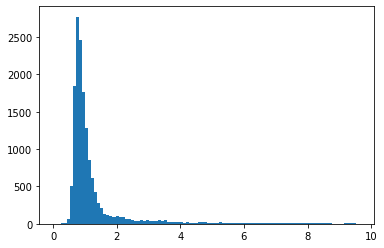

In [0]:
test(model, train_dl, many_channels = False, decision_boundary = median)

Accuracy: 0.67448738170347
Precision: 0.678515625
Recall: 0.6771929824561403
F1: 0.6778536585365853
Confusion Matrix: 
        0       1
0  1684.0   823.0
1   828.0  1737.0
(5072,)


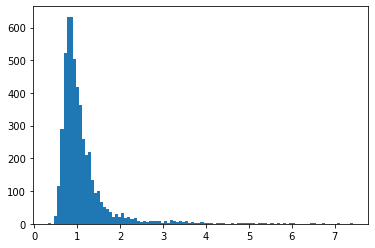

In [0]:
test(model, test_dl, many_channels = False, decision_boundary = median)

In [0]:
PATH = './spect_cnn_rnn_eeg_tolga6'
print('Save state of network...')
answer = None
while answer not in ("Y", "N"):
    answer = input("Enter Y or N: ")
    if answer == "Y": # Save the current state of the network.
        torch.save(model.state_dict(), PATH + '.pth')
        np.save(PATH + 'hyperparameters', [bs, lr, total_epochs, N_HIDDEN, dropout, weight_decay, lr_decay_rate] )
        print('State of the network was saved.')
    elif answer == "N": # Move on without saving.
        print('State of the network was NOT saved.')
        continue
    else:
        print("Please enter yes or no.")

Save state of network...
Enter Y or N: Y
State of the network was saved.


In [0]:
[bs1, lr1, total_epochs1, momentum1] = np.load('hyperparameters.npy')

In [0]:
bs1

64.0

In [0]:
total_epochs

250